In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

Definição da SEED:

In [2]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED) # Numpy

# Carregando os dados

Os valores são números muito pequenos com muitas casas decimais, por isso é bom que o dataframe consiga representar isso também.

In [3]:
pd.set_option('display.float_format', '{:.20f}'.format)

Carregando os dados:

In [4]:
df_benign = pd.read_csv("data/dados benignos/mensagens_benignas.csv")
df_benign

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,3,193,0,0,0,-1
1,0.00012946128845210000,3,193,0,0,0,-1
2,0.00015544891357419999,3,193,0,0,0,-1
3,0.00015616416931149999,3,193,0,0,0,-1
4,0.00013208389282220000,2,194,24,0,-1,-1
...,...,...,...,...,...,...,...
2673812,0.00172662734985350001,1,165,88,-1,-1,-1
2673813,0.00108718872070310006,1,165,88,-1,-1,-1
2673814,0.00091290473937979998,1,165,88,-1,-1,-1
2673815,0.00008821487426757812,1,165,88,-1,-1,-1


In [5]:
df_malicious_random_dos = pd.read_csv("data/ataques/mensagens_maliciosas_random_dos.csv")
df_malicious_spoofing_zero_payload = pd.read_csv("data/ataques/mensagens_maliciosas_spoofing_zero_payload.csv")
df_malicious_zero_dos = pd.read_csv("data/ataques/mensagens_maliciosas_zero_dos.csv")

In [6]:
df_malicious_random_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,192,17,110,1,93
1,0.00037145614624020001,1,1061,225,-1,-1,-1
2,0.00169730186462400002,2,1412,198,237,-1,-1
3,0.00179910659790029999,1,2035,254,-1,-1,-1
4,0.00183224678039550001,3,544,66,102,79,-1
...,...,...,...,...,...,...,...
455997,0.00016474723815910000,4,192,207,106,1,92
455998,0.00016379356384270001,4,192,207,106,1,92
455999,0.00016403198242180000,4,192,207,106,1,92
456000,0.00016498565673819999,4,192,207,106,1,92


In [7]:
df_malicious_spoofing_zero_payload

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00161838531494139996,4,0,0,0,0,0
2,0.00169730186462400002,4,0,0,0,0,0
3,0.00061082839965819998,4,192,0,0,0,0
4,0.00175023078918450006,4,0,0,0,0,0
...,...,...,...,...,...,...,...
568457,0.00015544891357419999,3,193,0,0,0,-1
568458,0.00015711784362790001,3,193,0,0,0,-1
568459,0.00015830993652339999,3,193,0,0,0,-1
568460,0.00012922286987300001,2,194,0,0,-1,-1


In [8]:
df_malicious_zero_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00115513801574700006,4,0,0,0,0,0
2,0.00147318840026850004,4,0,0,0,0,0
3,0.00123977661132810006,4,0,0,0,0,0
4,0.00169897079467769990,4,0,0,0,0,0
...,...,...,...,...,...,...,...
741977,0.00014257431030270001,2,194,236,255,-1,-1
741978,0.00012278556823730000,2,194,236,255,-1,-1
741979,0.00013160705566400000,2,194,236,255,-1,-1
741980,0.00016975402832030000,4,192,147,117,1,95


Manipualação da quantidade/proporção dos dados:

In [9]:
# OPCIONAL!!!
len_min = min(len(df_benign),len(df_malicious_random_dos),len(df_malicious_spoofing_zero_payload),len(df_malicious_zero_dos))
NUM_OF_ATTACKS = 3

df_benign = df_benign.head(len_min * NUM_OF_ATTACKS)
df_malicious_random_dos = df_malicious_random_dos.head(len_min)
df_malicious_spoofing_zero_payload = df_malicious_spoofing_zero_payload.head(len_min)
df_malicious_zero_dos = df_malicious_zero_dos.head(len_min)

In [10]:
del len_min

# Tratando dados

## Normalização dos dados

Criação e uso do scaler:

In [11]:
scaler = MinMaxScaler()

scaler.fit(df_benign)

df_benign_scaled = pd.DataFrame(scaler.transform(df_benign), columns=df_benign.columns, index=df_benign.index)
df_malicious_random_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_random_dos), columns=df_malicious_random_dos.columns, index=df_malicious_random_dos.index)
df_malicious_spoofing_zero_payload_scaled = pd.DataFrame(scaler.transform(df_malicious_spoofing_zero_payload), columns=df_malicious_spoofing_zero_payload.columns, index=df_malicious_spoofing_zero_payload.index)
df_malicious_zero_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_zero_dos), columns=df_malicious_zero_dos.columns, index=df_malicious_zero_dos.index)

In [12]:
del df_benign
del df_malicious_random_dos
del df_malicious_spoofing_zero_payload
del df_malicious_zero_dos

In [13]:
df_benign_scaled

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
1,0.00030808475678313944,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
2,0.00036992865823693891,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
3,0.00037163078396501207,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
4,0.00031432588445274093,0.14285714285714284921,1.00000000000000000000,0.09411764705882352811,0.00390625000000000000,0.00000000000000000000,0.00000000000000000000
...,...,...,...,...,...,...,...
1368001,0.00230013923388447568,0.00000000000000000000,0.84736842105263165958,0.39215686274509803377,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
1368002,0.00026099261163954499,0.00000000000000000000,0.84736842105263165958,0.39215686274509803377,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
1368003,0.00234779875427076077,0.00000000000000000000,0.84736842105263165958,0.39215686274509803377,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
1368004,0.00268198277221792661,0.00000000000000000000,0.84736842105263165958,0.39215686274509803377,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000


## Criando Labels

In [14]:
list_labels_benign = [1] * len(df_benign_scaled)
list_labels_random_dos = [-1] * len(df_malicious_random_dos_scaled)
list_labels_spoofing_zero_payload = [-2] * len(df_malicious_spoofing_zero_payload_scaled)
list_labels_zero_dos = [-3] * len(df_malicious_zero_dos_scaled)

classifier_type = "mc"

## Criação de Janelas Temporais

Criação da função de divisão dos dados em janelas:

In [15]:
def create_slicing_windows(data, labels, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(labels[i + time_step])
    return np.array(X), np.array(Y)

Definição do tamanho da janela:

In [16]:
WINDOW_SIZE = 150

Criação de janelas deslizantes:

In [17]:
benign_windows, benign_labels = create_slicing_windows(df_benign_scaled, list_labels_benign, WINDOW_SIZE)
del df_benign_scaled, list_labels_benign

malicious_random_dos_windows, malicious_random_dos_labels = create_slicing_windows(df_malicious_random_dos_scaled, list_labels_random_dos, WINDOW_SIZE)
del df_malicious_random_dos_scaled, list_labels_random_dos

malicious_spoofing_zero_payload_windows, malicious_spoofing_zero_payload_labels = create_slicing_windows(df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload, WINDOW_SIZE)
del df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload

malicious_zero_dos_windows, malicious_zero_dos_labels = create_slicing_windows(df_malicious_zero_dos_scaled, list_labels_zero_dos, WINDOW_SIZE)
del df_malicious_zero_dos_scaled, list_labels_zero_dos

In [18]:
len(benign_windows), len(benign_windows[0])

(1367856, 150)

In [19]:
benign_windows

array([[[0.00000000e+00, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.08084757e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.69928658e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        ...,
        [3.66524407e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.70496033e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.17162761e-04, 1.42857143e-01, 1.00000000e+00, ...,
         3.90625000e-03, 0.00000000e+00, 0.00000000e+00]],

       [[3.08084757e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.69928658e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [3.71630784e-04, 

## Dividindo dados em Treino, Validação e Teste

Quantidade de dados benignos dividido pelo total:

In [20]:
len(benign_windows) / (len(benign_windows) + len(malicious_random_dos_windows) + len(malicious_spoofing_zero_payload_windows) + len(malicious_zero_dos_windows))

0.5000548363464078

Concatenação das janelas, em ordem:

In [21]:
data = np.vstack((benign_windows, malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [22]:
data_malicious = np.vstack((malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [23]:
data_labels = np.hstack((benign_labels, malicious_random_dos_labels, malicious_spoofing_zero_payload_labels, malicious_zero_dos_labels))

In [24]:
#del benign_windows
del malicious_random_dos_windows
del malicious_spoofing_zero_payload_windows
del malicious_zero_dos_windows

del benign_labels
del malicious_random_dos_labels
del malicious_spoofing_zero_payload_labels
del malicious_zero_dos_labels

Divisão em treino, validação e teste.

In [25]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data, data_labels, test_size=0.25, random_state=RANDOM_SEED)

In [26]:
val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, test_size=0.5, random_state=RANDOM_SEED)

In [27]:
del data
del val_test_data, val_test_labels

Shape dos dados de treino:

In [28]:
train_data.shape

(2051559, 150, 7)

# IAs

## LSTM (supervisionado)

Variável que define se é supervisionado ou não-supervisionado:

In [29]:
s_OR_ns = "s"

Quantidade de features, para o modelo lidar com as entradas:

In [30]:
FEATURES_COUNT = train_data.shape[2] # Número de features dos dados

Construção do modelo LSTM:

In [31]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES_COUNT)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, kernel_regularizer=l2(0.0000001)))

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')
#model.compile(optimizer="adam", loss='mse')

Definição da paciência:

In [32]:
PATIENCE = 4

Configuração do early stop:

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience= PATIENCE, restore_best_weights=True)

Definição da quantidade de épocas e da quantidade de batchs:

In [34]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [35]:
# Treinando o modelo
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/50
64112/64112 [==============================] - 1337s 21ms/step - loss: 0.1530 - val_loss: 0.0042
Epoch 2/50
64112/64112 [==============================] - 1328s 21ms/step - loss: 0.0988 - val_loss: 0.0029
Epoch 3/50
64112/64112 [==============================] - 1332s 21ms/step - loss: 0.0956 - val_loss: 0.0010
Epoch 4/50
64112/64112 [==============================] - 1325s 21ms/step - loss: 0.4522 - val_loss: 0.4667
Epoch 5/50
64112/64112 [==============================] - 1319s 21ms/step - loss: 0.2826 - val_loss: 0.0112
Epoch 6/50
64112/64112 [==============================] - 1316s 21ms/step - loss: 0.2665 - val_loss: 0.2907
Epoch 7/50
64112/64112 [==============================] - 1316s 21ms/step - loss: 0.2879 - val_loss: 0.0054


In [36]:
# Avaliando o modelo no conjunto de teste
loss = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)

10686/10686 [==============================] - 93s 9ms/step - loss: 0.0011
Test Loss: 0.0010944261448457837


In [38]:
predicts = model.predict(test_data)

10686/10686 [==============================] - 94s 9ms/step


In [39]:
predicts

array([[0.95683044],
       [0.95902973],
       [0.9430292 ],
       ...,
       [0.9700784 ],
       [0.96434003],
       [0.9612251 ]], dtype=float32)

In [40]:
len(predicts[predicts > 0]) / (len(predicts[predicts < 0]) + len(predicts[predicts > 0]))

0.4987819037396871

In [41]:
len(test_labels[test_labels < 0]), len(test_labels[test_labels > 0])

(171373, 170554)

In [42]:
len(predicts[predicts < 0]), len(predicts[predicts > 0])

(171380, 170547)

In [43]:
len(predicts[predicts < 0]) / len(test_labels[test_labels < 0]), len(predicts[predicts > 0]) / len(test_labels[test_labels > 0])

(1.0000408465744313, 0.9999589572803921)

In [44]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_e{EPOCHS}_p{PATIENCE}_bs{BATCH_SIZE}.keras')

In [45]:
dump(scaler, f"models/scales/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_e{EPOCHS}_p{PATIENCE}_bs{BATCH_SIZE}")

['models/scales/scaler_model_LSTM_s_mc_ws150_e50_p4_bs32']

In [ ]:
#del scaler
del history
del predicts
del loss

## LSTM (não-supervisionado) (NÃO TERMINADO!!!)

In [46]:
s_OR_ns = "ns"
classifier_type = "bc"

In [47]:
FEATURES_COUNT = benign_windows.shape[2]

In [48]:
# Construindo o modelo Autoencoder LSTM
inputs = Input(shape=(WINDOW_SIZE, FEATURES_COUNT))
encoded = LSTM(50, activation='tanh', return_sequences=False)(inputs)  # Codificador
decoded = RepeatVector(WINDOW_SIZE)(encoded)  # Decodificador
decoded = LSTM(FEATURES_COUNT, return_sequences=True)(decoded)

# Adicionando Dropout e Normalização em Batch
decoded = Dropout(0.1)(decoded)
decoded = BatchNormalization()(decoded)

# Camada de saída
outputs = Dense(FEATURES_COUNT, kernel_regularizer=l2(0.0000001))(decoded)

# Compilando o modelo
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')

In [49]:
PATIENCE = 4

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [51]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

In [52]:
history = model.fit(benign_windows, benign_windows, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
34197/34197 [==============================] - 1348s 39ms/step - loss: 0.0494 - val_loss: 0.0266
Epoch 2/50
34197/34197 [==============================] - 1337s 39ms/step - loss: 0.0507 - val_loss: 0.0318
Epoch 3/50
34197/34197 [==============================] - 1336s 39ms/step - loss: 0.0535 - val_loss: 0.0272
Epoch 4/50
34197/34197 [==============================] - 1346s 39ms/step - loss: 0.0532 - val_loss: 0.0317
Epoch 5/50
34197/34197 [==============================] - 1347s 39ms/step - loss: 0.0514 - val_loss: 0.0266


In [53]:
predicts = model.predict(data_malicious)

42737/42737 [==============================] - 733s 17ms/step


In [54]:
predicts

array([[[0.00469116, 0.26912168, 0.98672426, ..., 0.19228923,
         0.01910315, 0.31807357],
        [0.00467574, 0.2696274 , 0.9869922 , ..., 0.1858198 ,
         0.01830397, 0.3189496 ],
        [0.00467553, 0.2699398 , 0.9871517 , ..., 0.18506084,
         0.01764308, 0.31939727],
        ...,
        [0.00467578, 0.2699781 , 0.9871718 , ..., 0.18495844,
         0.01756711, 0.3194515 ],
        [0.00467578, 0.2699781 , 0.9871718 , ..., 0.18495844,
         0.01756711, 0.3194515 ],
        [0.00467578, 0.2699781 , 0.9871718 , ..., 0.18495844,
         0.01756711, 0.3194515 ]],

       [[0.00463558, 0.2674067 , 0.98580223, ..., 0.19136526,
         0.01881231, 0.3160206 ],
        [0.00461965, 0.267936  , 0.9860847 , ..., 0.18489432,
         0.01787265, 0.31692475],
        [0.00461946, 0.26824826, 0.9862444 , ..., 0.18413012,
         0.01720587, 0.3173725 ],
        ...,
        [0.0046197 , 0.2682869 , 0.98626477, ..., 0.18402602,
         0.0171281 , 0.3174274 ],
        [0.0

In [55]:
def plot_comparison(original_data, predicted_data, sample_index=0):
    """
    Função para comparar visualmente os dados originais com as predições do modelo autoencoder.

    Parâmetros:
        original_data (numpy.array): Os dados originais.
        predicted_data (numpy.array): As previsões geradas pelo modelo autoencoder.
        sample_index (int): O índice da amostra a ser plotada.
    """
    plt.plot(original_data[sample_index], label='Original')
    plt.plot(predicted_data[sample_index], label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Comparison of Original and Predicted Data')
    plt.legend()
    plt.show()

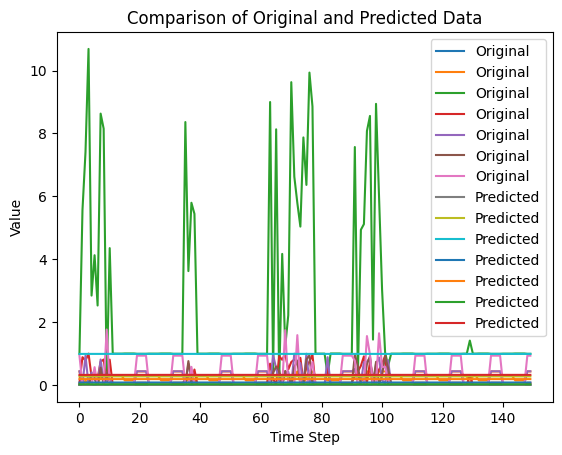

In [56]:
plot_comparison(data_malicious, predicts)

In [57]:
def classify_samples(original_data, predicted_data, threshold):
    """
    Função para classificar as amostras como benignas (1) ou malignas (-1) com base no erro de reconstrução.

    Parâmetros:
        original_data (numpy.array): Os dados originais.
        predicted_data (numpy.array): As previsões geradas pelo modelo autoencoder.
        threshold (float): O limiar de decisão para classificar as amostras.

    Retorna:
        numpy.array: Um array de classificação binária para cada amostra.
    """
    # Calcula o erro de reconstrução (MSE) para cada amostra
    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    # Classifica as amostras com base no limiar
    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    return classifications

In [58]:
TRESHOLD = 0.01

In [59]:
classifications = classify_samples(data_malicious, predicts, TRESHOLD)

In [60]:
len(classifications[classifications == -1]) / len(classifications)

0.9997331005092296

In [61]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_e{EPOCHS}_p{PATIENCE}_bs{BATCH_SIZE}.keras')

In [62]:
dump(scaler, f"models/scales/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_e{EPOCHS}_p{PATIENCE}_bs{BATCH_SIZE}")

['models/scales/scaler_model_LSTM_ns_bc_ws150_e50_p4_bs32']